Maching Learning Final Projection

Cole Kampa

Jacob McLaughlin

Zhiheng Sheng

# Introduction
Bubble chambers used in dark matter searches need to be able to count the number of bubbles produced by an event to achieve necessary levels of background discrimination. For the prototype scintillating bubble chamber (SBC) at Northwestern this counting was done by hand. Our objective is then to train an algorithm to perform this task automatically while maintaining a high degree of accuracy.

The input to the algorithm will be images take from the time when the chamber's data acquisition system triggered and took photos of the chamber. An example trigger image is displayed below
<img src="TriggerImageExample.png" style="width:250px"/>

This image is 2 different views of the same jar. The left slanted jar is a rotated frontal view while the right verical jar is an unroated side view. However, this image contains lots of irrelavant information about portions of the detector that do not ever change. Therefore, we take the difference between this image and the first frame of an event (taken a fixed amount of time before the trigger), which for the above event yields
<img src="DiffFirstEx.png" style="width:250px"/>

An image like this is produced for every event, and we perform supervised learning on extracted features and evaluate the performance of various classifiers.

This file will merely highlight important sections of code. The full code set is available here https://github.com/shengzhiheng/MachineLearningProject

In [1]:
import numpy as np
import tensorflow as tf

# Key Feature Extraction steps

In [2]:
class BubbleEvent:
    def __init__(self, File):
        #temp pixel arrays and event level meta data
        self.FileName = File
        Bot1PixelArray, Bot2PixelArray = BubbleEvent.GetPixelArray(self.FileName) #gets 2d array of pixel intensities
        self.Date, self.Run, self.EventID = BubbleEvent.GetRunInfo(self.FileName) #parses image name to get event info
        self.BubbleCount = 0
        #actual features to use to classify
        self.UsefulEdgeFeature0, self.UsefulEdgeFeature1, self.UsefulEdgeFeature2 = (GetEdgeFeature(
                                        DownSampleTheArray(2, Bot1PixelArray)) + 
                                        GetEdgeFeature(DownSampleTheArray(2, Bot2PixelArray))) #edge detect. sum
        self.UsefulBlobFeature = np.std(GetBlobs(Bot1PixelArray)) + np.std(GetBlobs(Bot2PixelArray)) #blob convalution deviation
        self.CountBlobPeakFeature = GetPeaks(Bot1PixelArray) + GetPeaks(Bot2PixelArray)
    def GetPixelArray(FileName):
        im = Image.open(FileName)
        PixelArray = np.asarray(im)
        Cutout = Cutout2D(PixelArray, (530,140), 235) #just cut out the parts of the image with bottles
        Bot1PixelArray = Cutout.data
        PixelArray =ndimage.rotate(PixelArray, -45)
        Cutout2 = Cutout2D(PixelArray, (270,310), 235) #other bottle view
        Bot2PixelArray = Cutout2.data
        return Bot1PixelArray, Bot2PixelArray
    def GetRunInfo(File):
        Date = int(File.split("/")[-1].split("_")[0]) #file should be date_run_event
        Run = int(File.split("/")[-1].split("_")[1])
        Event = int("{}{}{}".format(Date, Run,File.split("/")[-1].split("_")[2])) 
        return Date, Run, Event

Important features were extacted from the difference images and stored as BubbleEvent objects. For each bubble event the diff image file is provided as an input and 2 pixel arrays are extracted.

The first array is a cropped version of the full diff image that includes the verical view of the bubble chamber jar. For the event shown in the introduction this yields
<img src="View1Crop.png" style="width:200px"/>

The second array is a cropped view of the slanted view of the jar . For the event shown in the introduction this yields
<img src="View2Crop.png" style="width:200px"/>
These choices of cropping were chossen to highlight the area where bubbles may actually form.

These pixel arrays are then convaluted with a verical and horizontal edge detection kernel (the sobel kernal). The number of pixels with significant horizontal edges are stored in UsefulEdgeFeature0, vertical edges in UsefulEdgeFeature1, and the number pixels with significant horizontal and vertical edges are stored in UsefulEdgeFeature2. The results from each view of the jar are added together.

Next each view is fed to a blob detection kernal, which is the product of a laplacian kernel and a gaussian blur kernel (so a LOG kernel). The output of this kernel helps to emphasize bubbles in the views as below 
<img src="Bubble.png" style="width:200px"/>
For events with many bubbles you have more high pixel regions, so the standard deviation of the convovled image pixel value helps to tell you about how many bubbles are present. This value is stored in UsefulBlobFeature, again adding the contributions of each jar view.


The final step on each image is to perform a peak detection on the ouptu of the LOG kernel. The resuling image is scanned in a 15x15 box centered on a pixel of interest. Pixels that are both the maximum of the box centered on themsleves and sufficiently higher in intensity than the average pixel in that image will increase the peak count by 1. The peaks found (and their location) for an example event are displayed below.
<img src="Bubble.png" style="width:200px"/>
The result of peak detection is then stored in CountBlobPeakFeature, again adding the contributions of each jar view together.


These features were collected for every event in our dataset. This process takes ~0.8 seconds per image, so for all ~25000 images it takes ~20000 seconds or 5 hours on my laptop. To avoid this time sink, the results were compiled into an array which was then pickled (Events.p in the github). The classifiers then load this pickle to quickly access all the important features. 


A full overview of the functions not highlighted here is availabe in the github file BubbleClassification.ipynb.

# A simple multi-class classifier

A regularized, weighted multi-class softmax cost function is used as a first pass at classifying on the feature set. Weighting the data based on how many data points are in each class allows sufficient cost to be attributed to classes with multiple bubbles, where there are very few samples. Additionally, the input features are normalized since the scale of each features varies quite a bit.

Plots showing the cost history and misclassification history help check convergence, while confusion matrix plots indicate performance in each class. By looking at these plots and tweaking the classifier's parameters (e.g. step size $\alpha$, number of iterations, regularization scale $\lambda$), an adequate result can be achieved.

Two classifications were tested, one which specifies the number of bubbles (4-class) and one which only specifies whether or not a bubble is present (2-class).

In the 4-class run, since there is a single four bubble event, this event was moved into the three bubble class, which can now be thought of as $\geq 3$ bubbles.

In the 2-class run, all events with $\geq 1$ bubble are set to the label 1, which can now be thought of as $\geq 1$ bubble. In experiments looking for interesting events, it is often important to maintain a low false-negative rate (i.e. really a bubble, classifier says no bubble). To show how this can be achieved, the zero bubble class is downweighted by an extra factor of 2.

The function calls to load the data and run the classifiers are shown below, along with the output plots. To see the full set of functions used, see SimpleClassifier.ipynb or SimpleClassifier_funcs.py.

4 class classifier
Class Weights: {0: 6.228589224540641e-05, 1: 0.0001427959445951735, 2: 0.0038461538461538464, 3: 0.0625}



Overall Accuracy: 20120/23334 = 86.2%
Balanced Accuracy: 67.7%
Accuracy in each class: [0.98081595 0.60673997 0.43461538 0.6875    ]
2 class classifier
Class Weights: {0: 3.114294612270321e-05, 1: 0.00013738150844896276}



Overall Accuracy: 22004/23334 = 94.3%
Balanced Accuracy: 94.6%
Accuracy in each class: [0.93827468 0.95342767]


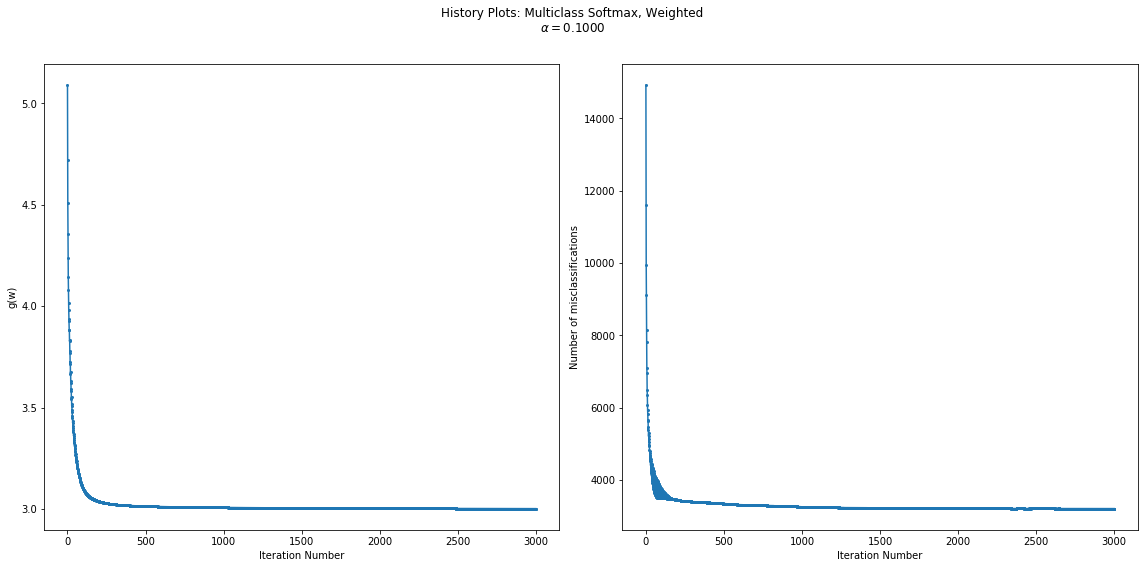

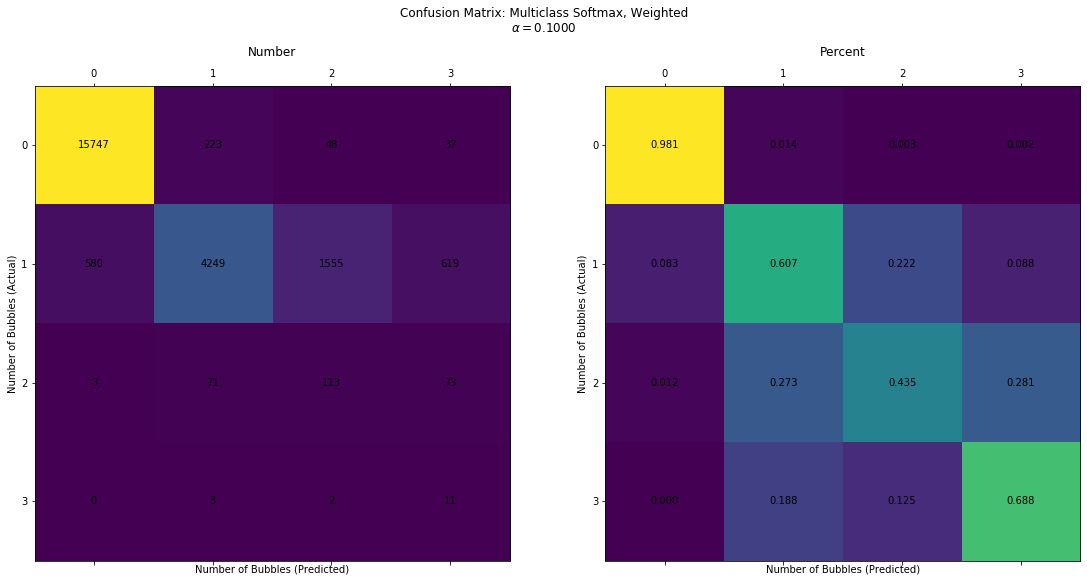

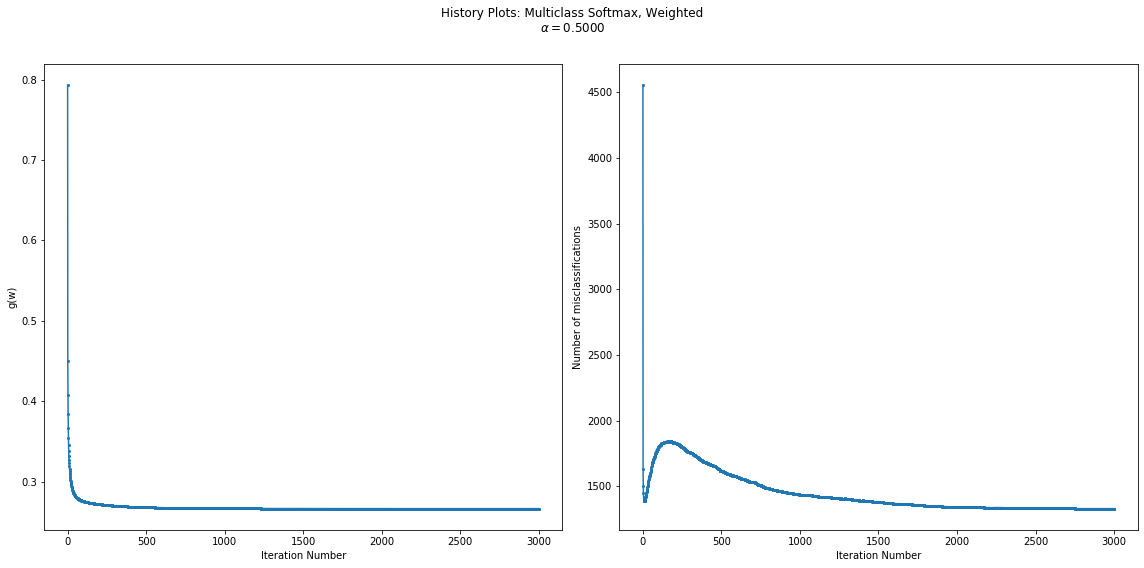

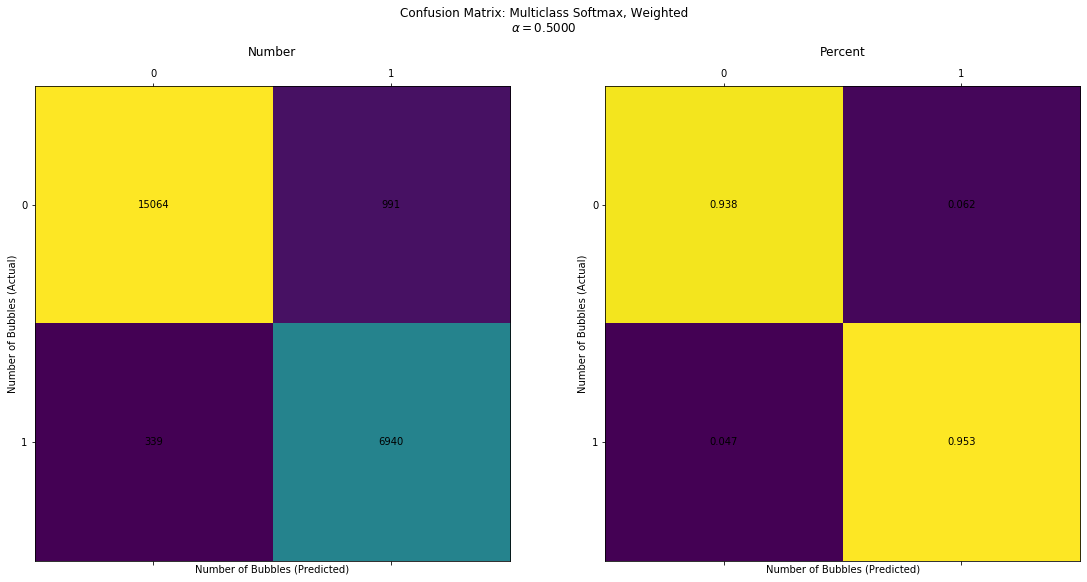

In [3]:
from SimpleClassifier_funcs import *
x, x_normed, y, y_2class = load_data()
print("4 class classifier")
it_num, wh, ch, mch, bah = run_classifier(x_normed, y, cost_func="softmax", weight_by_nclass=True,
                                          alpha=0.1, iterations=3000, lam=1e-8, balanced=True)
print("2 class classifier")
it_num, wh, ch, mch, bah = run_classifier(x_normed, y_2class, cost_func="softmax", weight_by_nclass=True,
                                          alpha=0.5, iterations=3000, lam=1e-5, balanced=False,
                                          n_mult={0: 2, 1: 1, 2: 1, 3: 1})

# Neural Net Model

A simple neural net model is then trained using the training data. The input data for each event is a three number feature set extracted from the images, and the output is 0 for no bubble or 1 for having bubbles. We used the `tensorflow.keras` package to construct our model. The model has only one hidden layer of 8 nodes, and the input, hidden and output layers are densely connected. Due to the small size of input and output, a more complicated model cannot achieve higher accuracy, but takes significantly longer to run and has a higher risk of overfitting. The loss function is the categorical cross entropy, and the metric that this model is evaluated against is the total accuracy. After training this model for 20 epochs, the loss minimized to 0.1396, and accuracy on the training set arrives at 96.13%. When evaluated on the test set, it achieved a loss of 0.1324 and accuracy of 96.29%. No class-dependent weights is used as that does not seem improve accuracy. See below for the core piece of code that defines, trains and evaluates the model, and the confusion matrix on the test set of 4667 events.

In [4]:
from BubbleNeuralNet import *
# get x and y from dataframe
df = load_feature()
x = np.array(df[['edgefeature', 'blobfeature', 'blobpeakfeature']])
y = 1-(np.array(df['bubblecount'])<=0)
for i in range(3):
    x[:,i] = gaussian_normalize(x[:,i])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = tf.keras.Sequential([ # define layers in model
    tf.keras.layers.Dense(8, activation=tf.nn.relu, input_shape=(3,)),
    tf.keras.layers.Dense(2)
])
weights = {0:1, 1:1} # define weights
model.compile(optimizer = 'adam', 
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
               metrics = ["accuracy"])
model.fit(x_train,y_train,class_weight=weights,epochs = 20,verbose=0) # train model on training set
test_accuracy = model.evaluate(x_test, y_test, verbose = 3) # output loss and accuracy on test set
y_pred = model.predict_classes(x_test) # get confusion matrix
print("Test set:\tLoss: %.4f, Accuracy: %.4f"%tuple(test_accuracy))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Test set:	Loss: 0.1369, Accuracy: 0.9610


| | Predicted No Bubble | Predicted Bubble |
|:---:|:---:|:---:|
| No Bubble | 3168 | 60 |
| Bubble | 115 | 1324 |

Since 3 and 4 bubble events in our dataset are rare, we could not achieve significant accuracy for those predictions. However, this model could still render useful because it can still reduce the number of events that need manual classification by a factor of 3. In the future, we could explore some other features that can better represent the number of bubbles in an image as opposed to just bubble / no bubble.

# Conclusions
The features we extracted perform fairly well at differentiating between images with bubbles and images without bubbles. However, the performance on counting bubbles leaves something to be desired. This could be addressed by using a data set that contains more multi-bubble events, but, even given our current data set, we could probably obtain better performance out of a convalutional neural network, rather than forcing the classifier to only work with our given feature sets.